In [4]:
!pip install tensorflow


In [5]:
!pip install keras

In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras .applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
data_dir = r"C:\Users\HP\Desktop\hand gesture\archive (1)\leapGestRecog"
os.listdir(data_dir)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 'leapGestRecog']

In [14]:
batch_size = 32
img_size = 224
num_classes = 10

def get_file_paths_and_labels(base_path):
    file_paths = []
    labels = []
    gesture_folders = [
        '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
        '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
    ]
    label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}
    
    for subject in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject)
        if os.path.isdir(subject_path):
            for gesture in gesture_folders:
                gesture_path = os.path.join(subject_path, gesture)
                if os.path.isdir(gesture_path):
                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)
                        file_paths.append(img_path)
                        labels.append(label_map[gesture])
    return file_paths, labels

# This should be defined outside, not inside the previous function
def display_images(file_paths, labels, label_map):
    unique_labels = list(label_map.values())
    label_to_name = {v: k for k, v in label_map.items()}
    
    plt.figure(figsize=(20, 20))
    for idx, label in enumerate(unique_labels):
        label_paths = [file_paths[i] for i in range(len(labels)) if labels[i] == label][:5]
        for i, img_path in enumerate(label_paths):
            img = load_img(img_path, color_mode='grayscale', target_size=(img_size, img_size))
            img = img_to_array(img) / 255.0
            plt.subplot(len(unique_labels), 5, idx * 5 + i + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(label_to_name[label])
            plt.axis('off')

    plt.show()

# Use the functions
file_paths, labels = get_file_paths_and_labels(data_dir)
print(f"First 10 file paths: {file_paths[:10]}")
print(f"First 10 labels: {labels[:10]}")

First 10 file paths: ['C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0001.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0002.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0003.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0004.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0005.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0006.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0007.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0008.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\\leapGestRecog\\00\\01_palm\\frame_00_01_0009.png', 'C:\\Users\\HP\\Desktop\\hand gesture\\archive (1)\

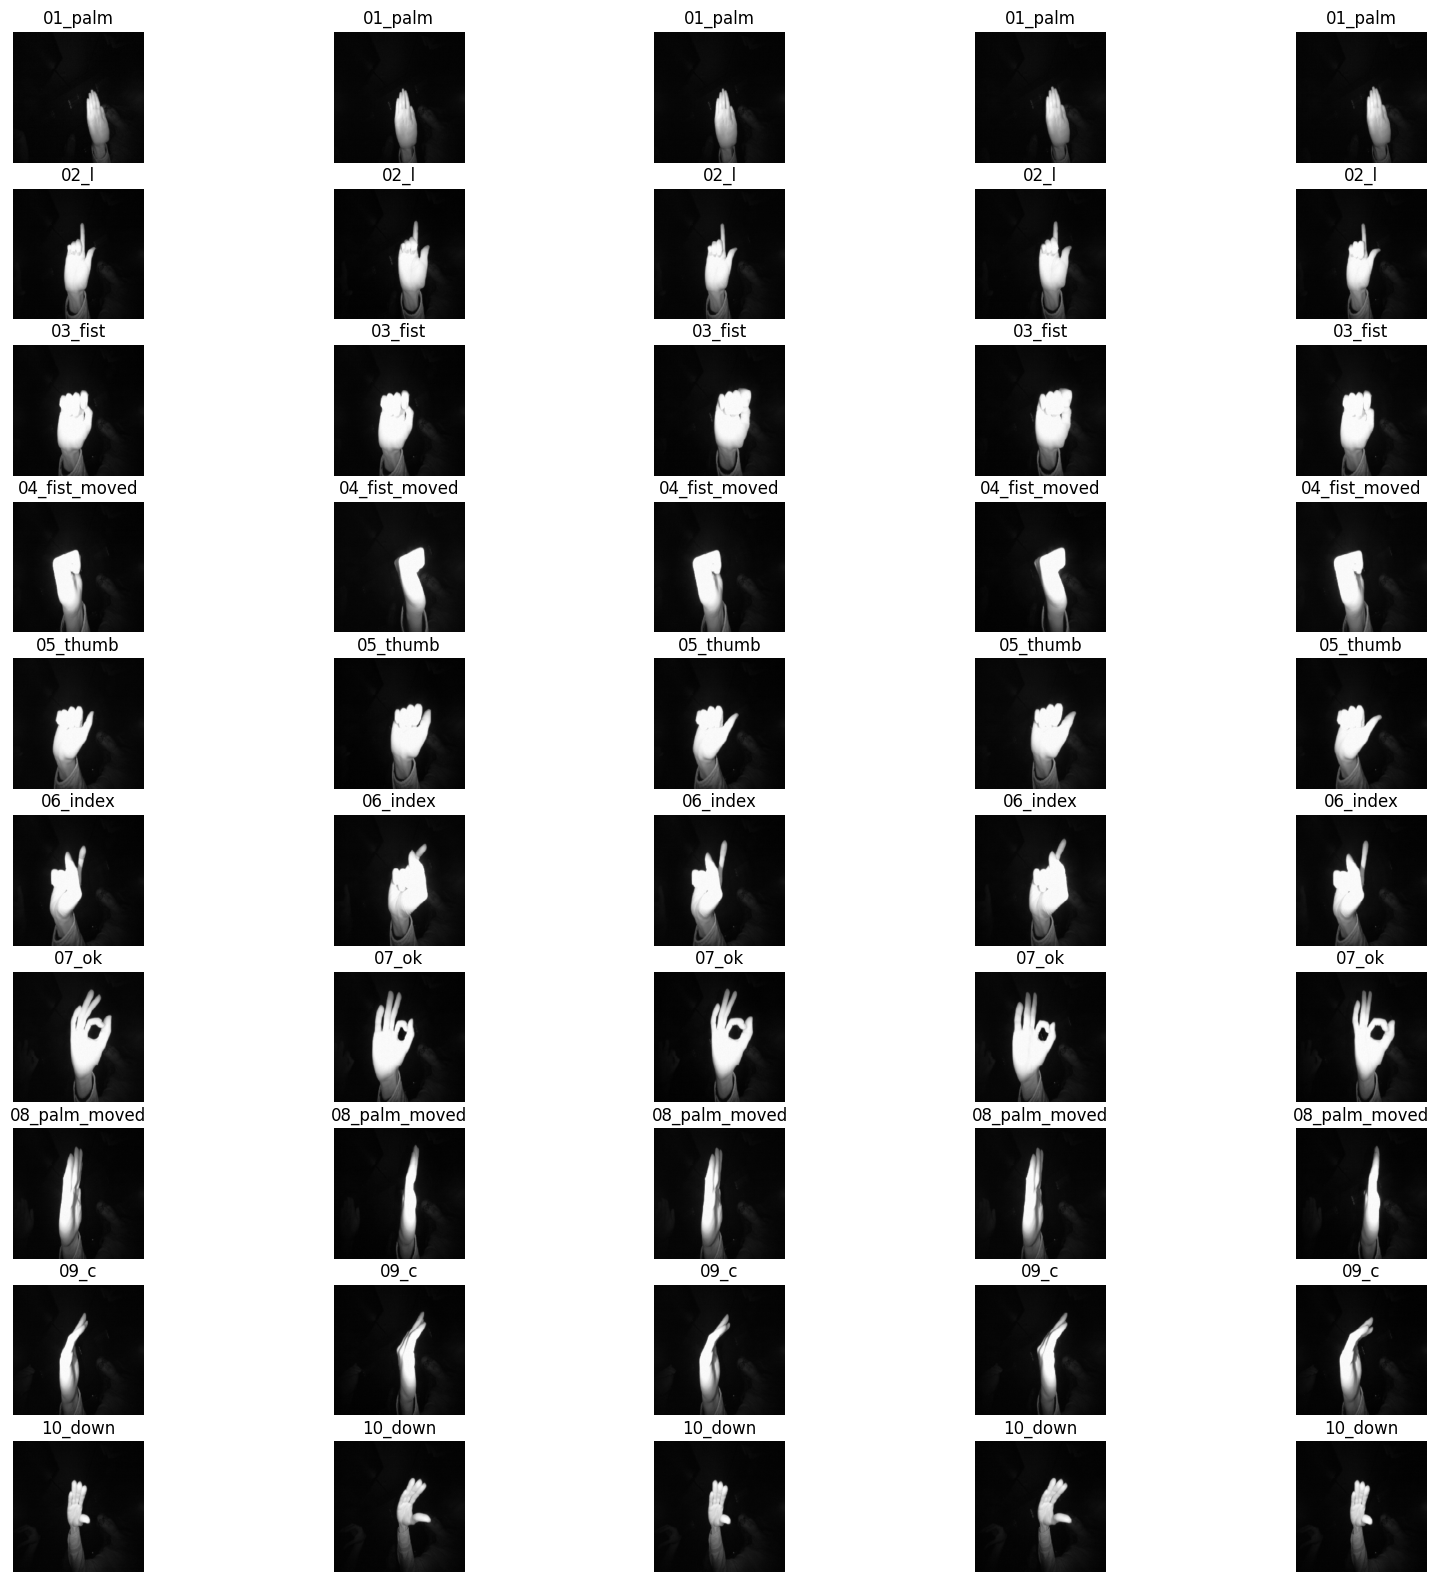

In [15]:
gesture_folders = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
    '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
]
label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}

# Display images
display_images(file_paths, labels, label_map)

In [16]:
data = list(zip(file_paths, labels))
np.random.shuffle(data)
file_paths, labels = zip(*data)
labels_str = [str(label) for label in labels]
dataframe = pd.DataFrame({'filename': file_paths, 'class': labels_str})
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(128,128,3)
)
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras import regularizers
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu' , kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
conv_base.trainable = False
model.summary()
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = dataframe,
    target_size=(128,128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = dataframe,
    target_size=(128,128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,814,666 (64.14 MB)

 Trainable params: 2,099,978 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 16000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.


In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights=True
        ) 
    ]
)   

Epoch 1/20


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1195s 2s/step - accuracy: 0.5702 - loss: 4.1967 - val_accuracy: 0.9392 - val_loss: 1.2440
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1206s 2s/step - accuracy: 0.9061 - loss: 1.1850 - val_accuracy: 0.9690 - val_loss: 0.7781
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1135s 2s/step - accuracy: 0.9383 - loss: 0.8020 - val_accuracy: 0.9768 - val_loss: 0.5835
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1081s 2s/step - accuracy: 0.9476 - loss: 0.6258 - val_accuracy: 0.9827 - val_loss: 0.4671
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1300s 3s/step - accuracy: 0.9585 - loss: 0.5198 - val_accuracy: 0.9805 - val_loss: 0.4079
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1130s 2s/step - accuracy: 0.9577 - loss: 0.4586 - val_accuracy: 0.9815 - val_loss: 0.3608
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1131s 2s/step - accuracy: 0.9615 - loss: 0.4222 - val_accuracy: 0.9805 - val_loss: 0.3436
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1130s 2s/step - accuracy: 0.9576 - loss: 0.3949 - val_accurac

125/125 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9848 - loss: 0.2116


Validation Accuracy: 98.60%


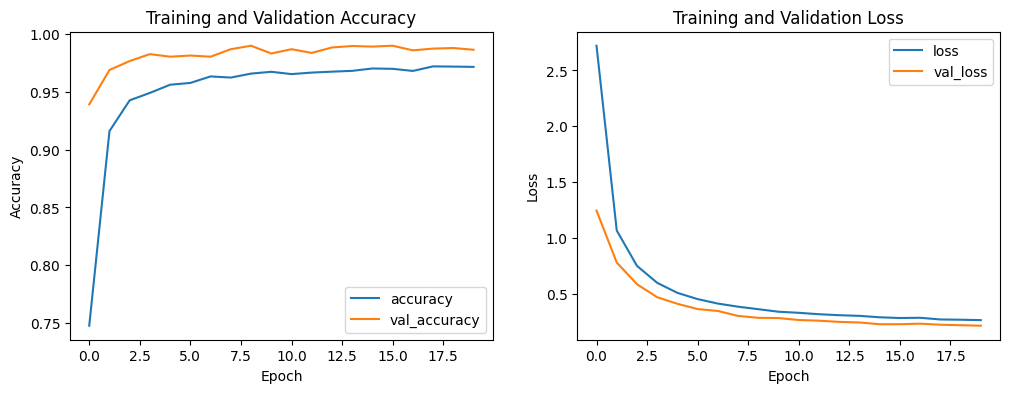

In [19]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')
model.save('hand gesture recognition_model.h5') 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 

In [25]:
from tensorflow.keras.models import load_model
loaded_model = load_model('hand gesture recognition_model.h5')
img_size = 128
gesture_classes = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', 
    '05_thumb', '06_index', '07_ok', '08_palm_moved', 
    '09_c', '10_down'
]
def load_predict_and_display(img_path, model, img_size):
    # Load and preprocess the image (RGB)
    img = load_img(img_path, color_mode='rgb', target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict the gesture
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display the image and the predicted class
    plt.imshow(img_array.squeeze(), cmap='gray')  # Remove 'cmap' if image is in RGB
    plt.title(f'Predicted Gesture: {gesture_classes[predicted_class]}')
    plt.axis('off')
    plt.show()
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


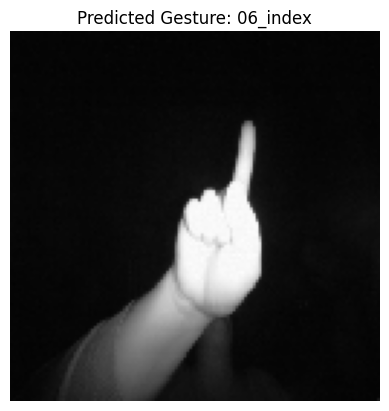

In [27]:
test_img_path =r"C:\Users\HP\Desktop\hand gesture\archive (1)\leapGestRecog\05\06_index\frame_05_06_0002.png"

# Predict and display the gesture
load_predict_and_display(test_img_path, loaded_model, img_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


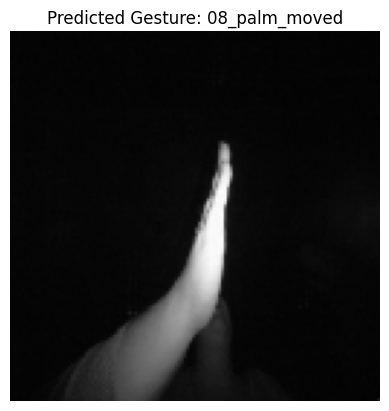

In [28]:
test_img_path =r"C:\Users\HP\Desktop\hand gesture\archive (1)\leapGestRecog\05\08_palm_moved\frame_05_08_0008.png"

# Predict and display the gesture
load_predict_and_display(test_img_path, loaded_model, img_size)